Revert to `numpy-1.22.1` after using Devito

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from devito import *
from examples.seismic import Model, plot_shotrecord, plot_velocity
from examples.seismic.source import Receiver, RickerSource, TimeAxis
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["animation.html"] = "jshtml"

from sympy import init_printing, latex

init_printing(use_latex="mathjax")

# Some ploting setup
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("xtick", labelsize=20) 
plt.rc("ytick", labelsize=20)

In [ ]:
# ModelElastic
nx = 201      # grid points in x
nz = 201      # grid points in z
dx = 75.0     # grid increment in x
so = 8        # spatial order
to = 2        # time order
bl = 200      # boundary cells


vp = np.ones((nz, nx)) * 4.5
vs = np.ones((nz, nx)) * 2.8
rho = np.ones((nz, nx)) * 2.8 # Density


w0 = 150
rw0 = 0
for ii in range(25,65,1):
    vp[rw0,ii:ii+w0] = vp[rw0,ii:ii+w0]/1.5
    vs[rw0,ii:ii+w0] = vs[rw0,ii:ii+w0]/1.5
    rho[rw0,ii:ii+w0] = 2.3
    w0 -= 2
    rw0 += 1
w0 = 100
rw0 = 0
for ii in range(50,70,2):
    vp[rw0,ii:ii+w0] = vp[rw0,ii:ii+w0]/1.2
    vs[rw0,ii:ii+w0] = vs[rw0,ii:ii+w0]/1.2
    rho[rw0,ii:ii+w0] = 1.8
    w0 -= 4
    rw0 += 1

mu = rho * vs**2
lam = rho * vp**2 - 2 * mu

# fig,ax = plt.subplots(1,3,figsize=(13,3))
# ax[0].imshow(vp, aspect="auto")
# ax[1].imshow(vs, aspect="auto")
# ax[2].imshow(rho, aspect="auto")
# plt.show()

model = Model(origin=(0,0), vp=vp.T, vs=vs.T, b=1/rho.T, lam=lam.T, mu=mu.T, 
              shape=(nx, nz), spacing=(dx, dx), space_order=so, nbl=bl, bcs="mask")

Operator `initdamp` ran in 0.01 s


['vp', 'damp', 'vs', 'b', 'epsilon', 'delta', 'theta', 'phi', 'qp', 'qs', 'lam', 'mu']
Grid[extent=(45000.0, 45000.0), shape=(601, 601), dimensions=(x, y)]


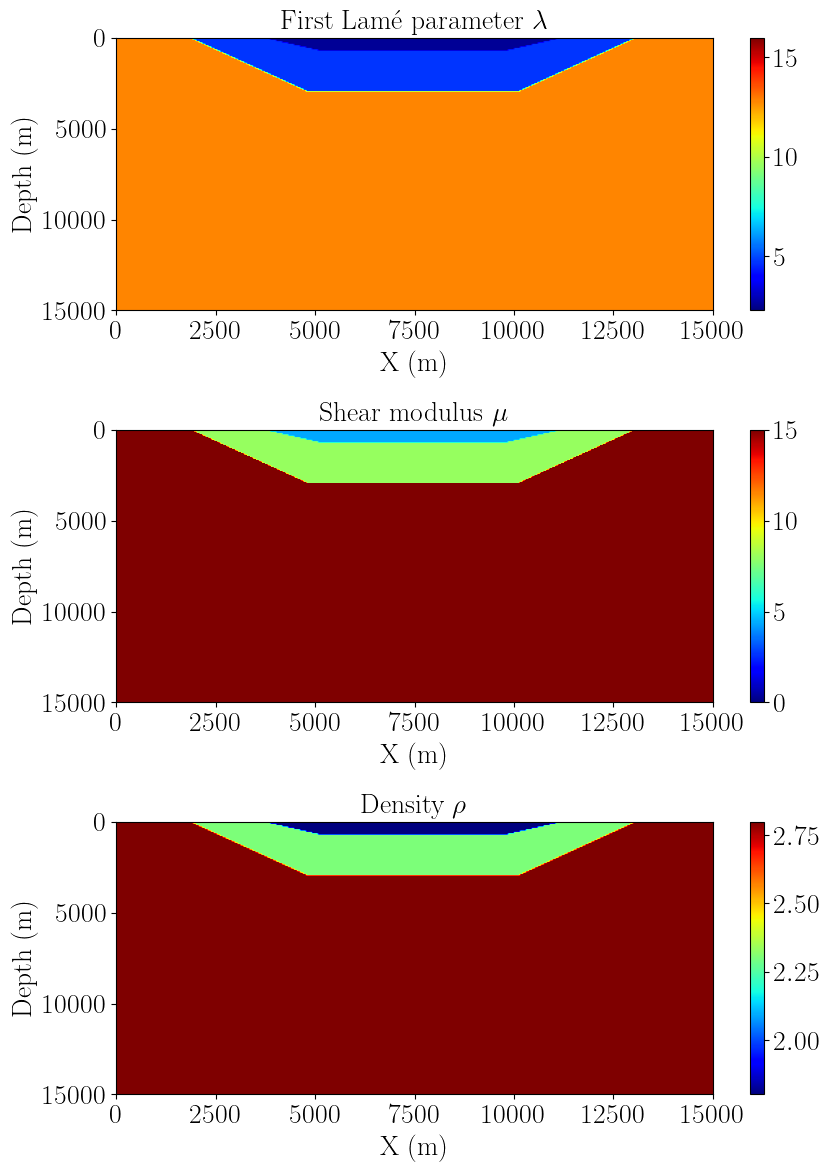

In [ ]:
#NBVAL_SKIP
aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {"cmap": "jet", "extent": [model.origin[0], model.origin[0] + model.domain_size[0],
                                               model.origin[1] + model.domain_size[1], model.origin[1]]}
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))

slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

img1 = ax[0].imshow(np.transpose(model.lam.data[slices]), vmin=1.5**2, vmax=4.0**2, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"First Lam\"e parameter $\lambda$", fontsize=20)
ax[0].set_xlabel("X (m)", fontsize=20)
ax[0].set_ylabel("Depth (m)", fontsize=20)
ax[0].set_aspect("auto")


img2 = ax[1].imshow(np.transpose(model.mu.data[slices]), vmin=0, vmax=15, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title(r"Shear modulus $\mu$", fontsize=20)
ax[1].set_xlabel("X (m)", fontsize=20)
ax[1].set_ylabel("Depth (m)", fontsize=20)
ax[1].set_aspect("auto")


img3 = ax[2].imshow(1/np.transpose(model.b.data[slices]), **plt_options_model) #vmin=1.0, vmax=3.0, 
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Density $\rho$", fontsize=20)
ax[2].set_xlabel("X (m)", fontsize=20)
ax[2].set_ylabel("Depth (m)", fontsize=20)
ax[2].set_aspect("auto")


plt.tight_layout()
plt.show()

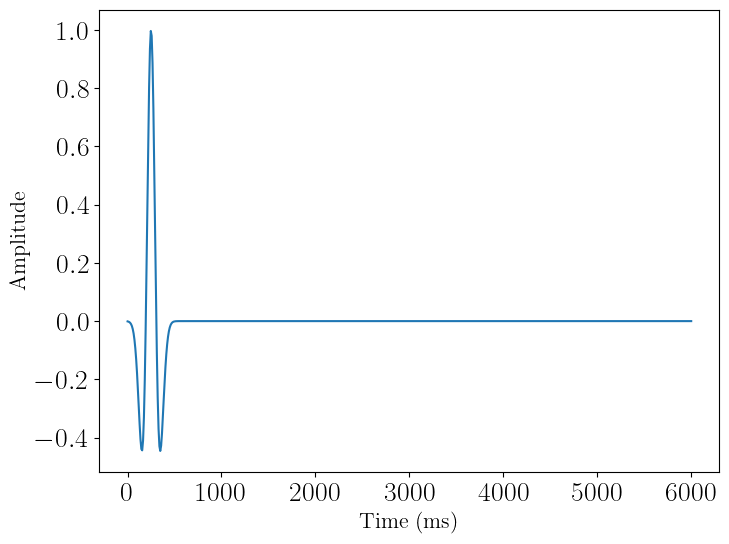

In [4]:
# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 6000.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.004, time_range=time_range)
src.coordinates.data[:] = [7500., 7500.]

#NBVAL_SKIP

src.show()

In [5]:
# Now we create the velocity and pressure fields

x, z = model.grid.dimensions
t = model.grid.stepping_dim
time = model.grid.time_dim
s = time.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to, save=time_range.num)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

In [ ]:
# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=s*src)

rz = 5 # Depth of receivers

# The receiver
nrec = 201
rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec.coordinates.data[:, -1] = rz

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, -1] = rz

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, -1] = rz

rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])

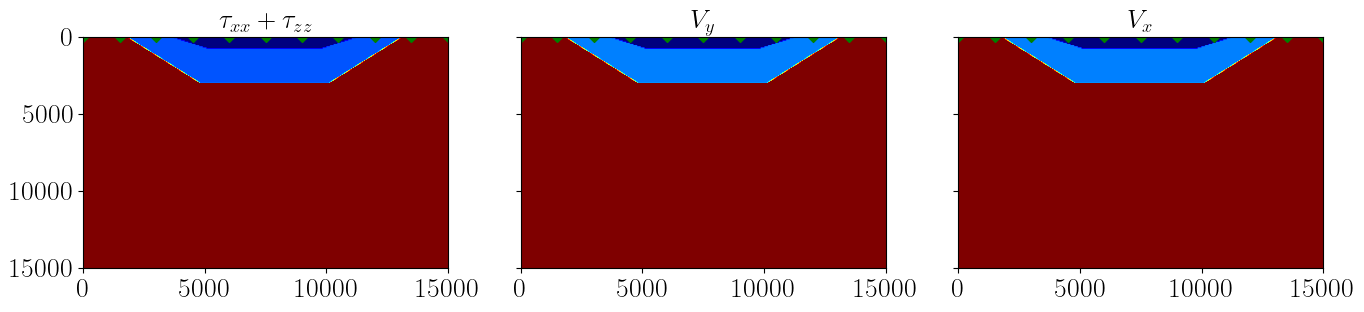

In [ ]:
#NBVAL_SKIP

plt_options_model = {"cmap": "jet", "extent": [model.origin[0], model.origin[0] + model.domain_size[0],
                                               model.origin[1] + model.domain_size[1], model.origin[1]]}

fig,ax = plt.subplots(1,3,figsize=(16,3),sharey=True)
ax[0].imshow(lam, aspect="auto", **plt_options_model),ax[0].set_title(r"$\tau_{xx} + \tau_{zz}$")
ax[0].scatter(rec.coordinates.data[::20, 0],rec.coordinates.data[::20, 1],s=25, c="green", marker="D")
ax[1].imshow(vp, aspect="auto", **plt_options_model),ax[1].set_title(r"$V_{y}$")
ax[1].scatter(rec2.coordinates.data[::20, 0],rec2.coordinates.data[::20, 1],s=25, c="green", marker="D")
ax[2].imshow(vp, aspect="auto", **plt_options_model),ax[2].set_title(r"$V_{x}$")
ax[2].scatter(rec3.coordinates.data[::20, 0],rec3.coordinates.data[::20, 1],s=25, c="green", marker="D")

plt.show()

# plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data[::20, :])
# plot_velocity(model, source=src.coordinates.data, receiver=rec2.coordinates.data[::20, :])
# plot_velocity(model, source=src.coordinates.data, receiver=rec3.coordinates.data[::20, :])

In [8]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).transpose(inner=False))
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] + src_xx + src_zz + rec_term)

In [43]:
print(v.time_order)
print(ro._eval_at(v[0]).evaluate)
print(mu._eval_at(v[0]).evaluate)
print(u_v)
print(u_t)
print(f"N Timesteps: {int(tn/model.critical_dt)}")

2
0.5*b(x, y) + 0.5*b(x + h_x, y)
0.5*mu(x, y) + 0.5*mu(x + h_x, y)
Eq(Vector(v_x(time + dt, x + h_x/2, y), v_y(time + dt, x, y + h_y/2)), Vector(dt*((Derivative(t_xx(t, x, y), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2), y))*b(x, y) + v_x(time, x + h_x/2, y)/dt)*damp(x, y), dt*((Derivative(t_xy(t, x + h_x/2, y + h_y/2), x) + Derivative(t_yy(t, x, y), y))*b(x, y) + v_y(time, x, y + h_y/2)/dt)*damp(x, y)))
Eq(Matrix([[t_xx(t + dt, x, y), t_xy(t + dt, x + h_x/2, y + h_y/2)], [t_xy(t + dt, x + h_x/2, y + h_y/2), t_yy(t + dt, x, y)]]), Matrix([[dt*((Derivative(v_x(time + dt, x + h_x/2, y), x) + Derivative(v_y(time + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_x(time + dt, x + h_x/2, y), x) + t_xx(t, x, y)/dt)*damp(x, y), dt*((Derivative(v_x(time + dt, x + h_x/2, y), y) + Derivative(v_y(time + dt, x, y + h_y/2), x))*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2)/dt)*damp(x, y)], [dt*((Derivative(v_x(time + dt, x + h_x/2, y), y) + Derivative(v_y(time + dt, x, y + h_y/2), x))*mu(x,

In [ ]:
#NBVAL_IGNORE_OUTPUT
# Full run for 6 secs to plot the wavefield
dtm = model.critical_dt
op(dt=dtm, time=int(tn/dtm))

Operator `Kernel` ran in 1.58 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=1.5636780000000015, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.000432000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.004414999999999978, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.0031739999999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section4', rank=None),
  PerfEntry(time=0.003172999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

### Plot and save the vertical velocity animation

In [51]:
plt.ioff()

scale = .5*1e-3

divi = 1

plt_options_model = {"extent": [model.origin[0] , model.origin[0] + model.domain_size[0],
                                model.origin[1] + model.domain_size[1], model.origin[1]],"aspect":"auto"}

# Initialize animated plot
fig,ax = plt.subplots(figsize=(8,5))
image = ax.imshow(np.transpose(v[1].data[0][slices]), vmin=-scale, vmax=scale, **plt_options_model, cmap="seismic")
ax.imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, alpha=.5, **plt_options_model, cmap="jet")
ax.set_title(r"$V_{y}$"), ax.set_xlabel("Distance (m)"), ax.set_ylabel("Depth (m)")

# Animate the pressure fields
def update(itr):
    image.set_array(np.transpose(v[1].data[itr*divi][slices]))
    return [image]

ani = FuncAnimation(fig, update, frames=int(v[1].data.shape[0]/divi), blit=False, repeat=False)
ani.save(filename="output/elastic_2D.mp4", writer="ffmpeg", fps=30, dpi=200, savefig_kwargs={"pad_inches": 0})

### Plot static wavefield snapshots

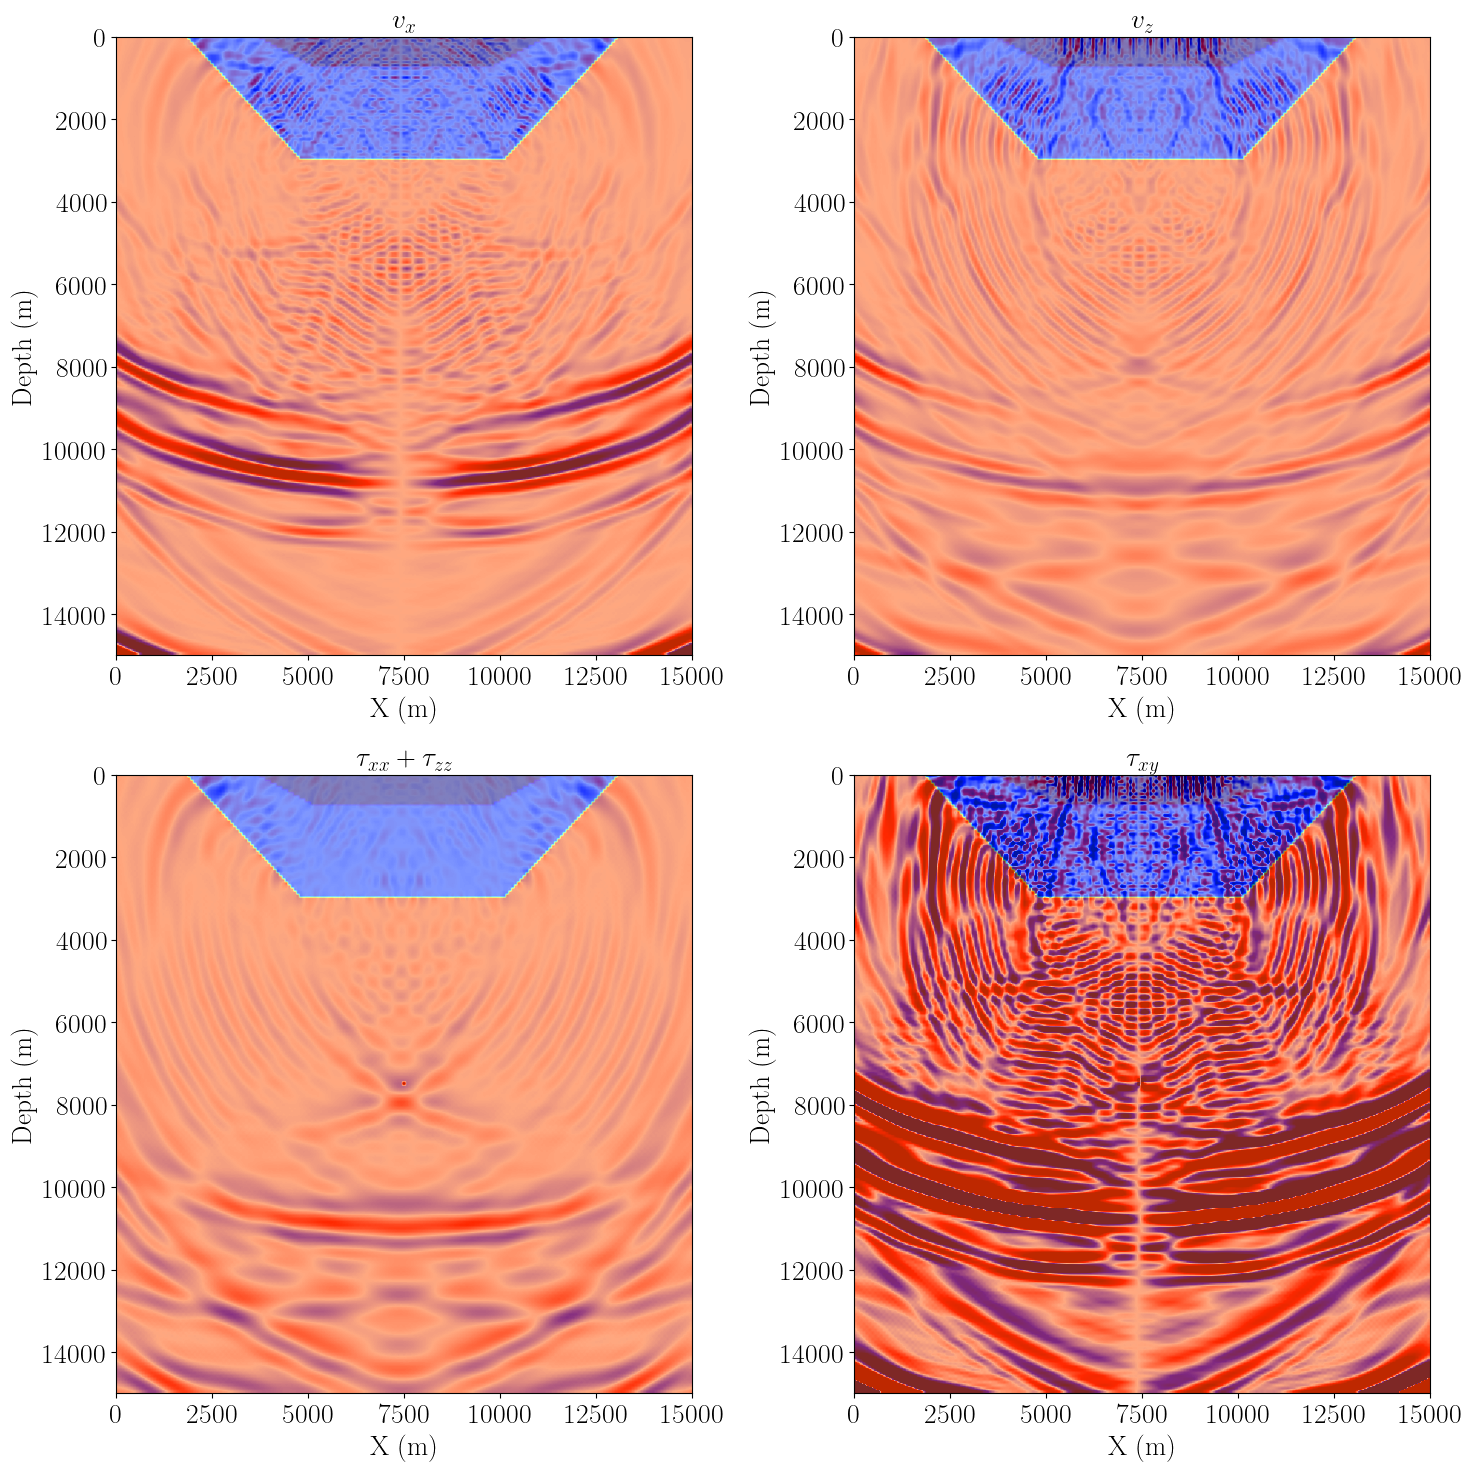

In [ ]:
#NBVAL_SKIP
scale = .5*1e-3

for i in range(1000):
    plt.close()

plt_options_model = {"extent": [model.origin[0] , model.origin[0] + model.domain_size[0],
                                model.origin[1] + model.domain_size[1], model.origin[1]]}


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax[0, 0].imshow(np.transpose(v[0].data[-1][slices]), vmin=-scale, vmax=scale, cmap="seismic", **plt_options_model)
ax[0, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 0].set_aspect("auto")
ax[0, 0].set_xlabel("X (m)", fontsize=20)
ax[0, 0].set_ylabel("Depth (m)", fontsize=20)
ax[0, 0].set_title(r"$v_{x}$", fontsize=20)

ax[0, 1].imshow(np.transpose(v[1].data[-1][slices]), vmin=-scale, vmax=scale, cmap="seismic", **plt_options_model)
ax[0, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[0, 1].set_aspect("auto")
ax[0, 1].set_title(r"$v_{z}$", fontsize=20)
ax[0, 1].set_xlabel("X (m)", fontsize=20)
ax[0, 1].set_ylabel("Depth (m)", fontsize=20)

ax[1, 0].imshow(np.transpose(tau[0,0].data[0][slices]+tau[1,1].data[0][slices]),
             vmin=-10*scale, vmax=10*scale, cmap="seismic", **plt_options_model)
ax[1, 0].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet",
               alpha=.5, **plt_options_model)
ax[1, 0].set_aspect("auto")
ax[1, 0].set_title(r"$\tau_{xx} + \tau_{zz}$", fontsize=20)
ax[1, 0].set_xlabel("X (m)", fontsize=20)
ax[1, 0].set_ylabel("Depth (m)", fontsize=20)


ax[1, 1].imshow(np.transpose(tau[0,1].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic", **plt_options_model)
ax[1, 1].imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5, **plt_options_model)
ax[1, 1].set_aspect("auto")
ax[1, 1].set_title(r"$\tau_{xy}$", fontsize=20)
ax[1, 1].set_xlabel("X (m)", fontsize=20)
ax[1, 1].set_ylabel("Depth (m)", fontsize=20)


plt.tight_layout()
plt.show()

### Plot the shot records

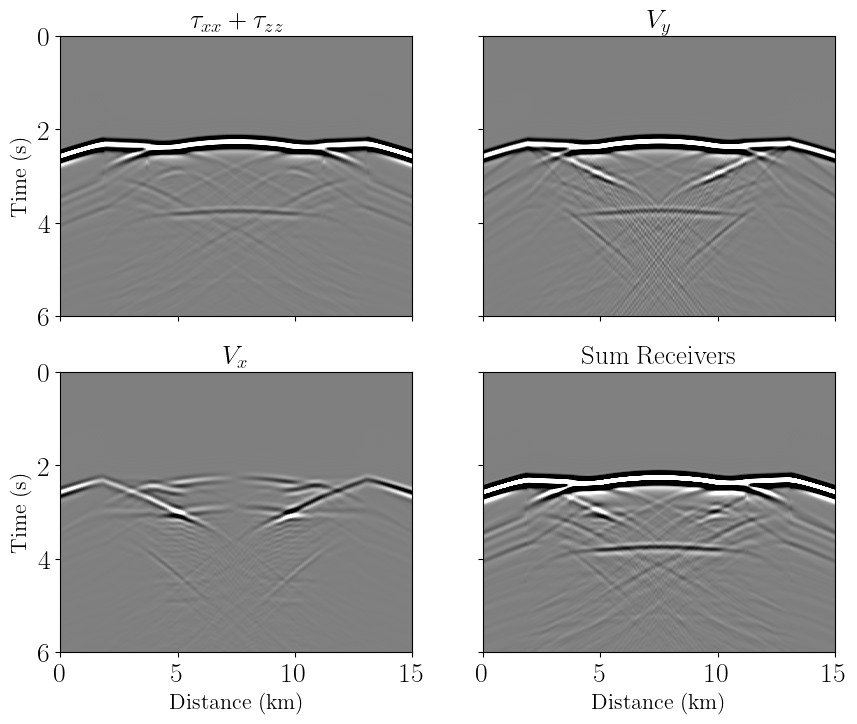

In [104]:
plt_options_model = {"cmap": "gray", "extent": [model.origin[0], model.origin[0] + model.domain_size[0]/1e3, tn/1e3, t0]}

r_sum = rec.data + rec2.data + rec3.data

# Calculate the scales of the data
rc1_sc,rc2_sc = np.max(rec.data) / 10.,np.max(rec2.data) / 10.
rc3_sc,rc4_sc = np.max(rec3.data) / 2.,np.max(r_sum) / 20.

fig,ax = plt.subplots(2,2,figsize=(10,8),sharex=True,sharey=True)
ax = ax.flatten()
ax[0].imshow(rec.data, aspect="auto", vmin=-rc1_sc, vmax = rc1_sc, **plt_options_model),ax[0].set_title(r"$\tau_{xx} + \tau_{zz}$")
ax[1].imshow(rec2.data, aspect="auto", vmin=-rc2_sc, vmax = rc2_sc, **plt_options_model),ax[1].set_title(r"$V_{y}$")
ax[2].imshow(rec3.data, aspect="auto", vmin=-rc3_sc, vmax = rc3_sc, **plt_options_model),ax[2].set_title(r"$V_{x}$")
ax[3].imshow(r_sum, aspect="auto", vmin=-rc4_sc, vmax = rc4_sc, **plt_options_model),ax[3].set_title("Sum Receivers")
ax[0].set_ylabel("Time (s)"),ax[2].set_ylabel("Time (s)"),ax[2].set_xlabel("Distance (km)"),ax[3].set_xlabel("Distance (km)")

plt.savefig("output/elastic_rcv_2D.png",bbox_inches="tight",dpi=200)
plt.show()


# plot_shotrecord(rec.data, model, t0, tn)
# plot_shotrecord(rec2.data, model, t0, tn)
# plot_shotrecord(rec3.data, model, t0, tn)

(656, 201)


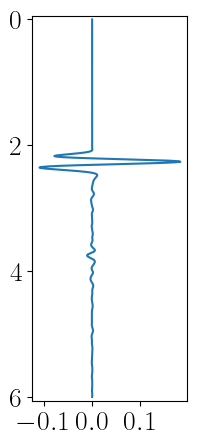

In [103]:
print(rec.data.shape)

plt.figure(figsize=(2,5))
plt.plot(r_sum[:,100],time_range.time_values/1e3)
plt.gca().invert_yaxis(),plt.margins(y=0.01)
plt.show()

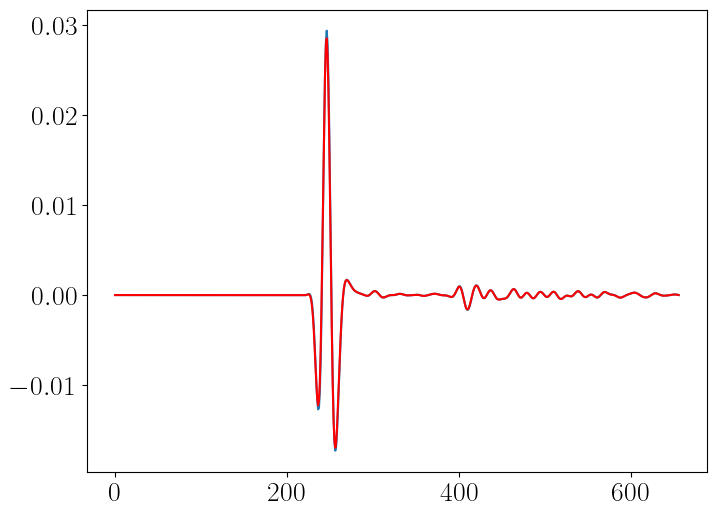

In [28]:
for i in range(1000):
    plt.close()

plt.plot(v[1].data[:,slices[0],slices[1]][:,100,0])
plt.plot(rec2.data[:,100],c="r")
# plt.plot(v[1].data[:,200,250])
plt.show()